In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from pathlib import Path as Path 

In [2]:
spotify_charts = pd.read_csv("charts.csv")

In [65]:
spotify_charts.head(3)

,title,rank,date,artist,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,Argentina,top200,MOVE_DOWN,210943.0


In [3]:
spotify_charts.dtypes

title       object
rank         int64
date        object
artist      object
url         object
region      object
chart       object
trend       object
streams    float64
dtype: object

In [4]:
del spotify_charts['url']

In [5]:
spotify_charts['date'] = pd.to_datetime(spotify_charts['date'], format="%Y-%m-%d")

In [34]:
spotify_charts['region'].nunique() # should use category dtype 

70

In [35]:
spotify_charts['trend'].nunique() # should use category dtype 

4

In [6]:
print('Memory usage of dataframe is {:2f} MB'.format(spotify_charts.memory_usage().sum() / 1024**3))

Memory usage of dataframe is 1.560063 MB


In [7]:
def reduce_memory_usage(df):
    for col in df.columns: 
        if col == 'rank':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
        elif col == 'streams':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif col != 'title' and col != 'artist' and col != 'date':
            df[col] = df[col].astype('category')

In [8]:
reduce_memory_usage(spotify_charts)
print('Memory usage of dataframe is {:2f} MB'.format(spotify_charts.memory_usage().sum() / 1024**3))

Memory usage of dataframe is 0.804410 MB


In [9]:
spotify_charts.isna().sum()

title           11
rank             0
date             0
artist          18
region           0
chart            0
trend            0
streams    5851610
dtype: int64

In [10]:
spotify_charts['streams'] = spotify_charts['streams'].fillna(0)
spotify_charts['title'] = spotify_charts['title'].fillna('Unlisted')
spotify_charts['artist'] = spotify_charts['artist'].fillna('Unlisted')

In [11]:
spotify_charts.dtypes

title              object
rank                int16
date       datetime64[ns]
artist             object
region           category
chart            category
trend            category
streams           float32
dtype: object

In [12]:
spotify_charts_cleaned_csv = spotify_charts.to_csv("spotify_charts_cleaned.csv")

In [13]:
Path('spotify_charts.db').touch()

In [24]:
spotify_conn = sqlite3.connect('spotify_charts.db')
spotify_cursor = spotify_conn.cursor()

In [ ]:
spotify_charts.to_sql('spotify_charts', spotify_conn, if_exists='append', index=False)

In [17]:
spotify_charts_init_query = pd.read_sql(''' SELECT * FROM spotify_charts LIMIT 5''', spotify_conn)
spotify_charts_init_query

,title,rank,date,artist,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01 00:00:00,Shakira,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01 00:00:00,Ricky Martin,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01 00:00:00,CNCO,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01 00:00:00,"J Balvin, Pharrell Williams, BIA, Sky",Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01 00:00:00,Daddy Yankee,Argentina,top200,MOVE_UP,153956.0


In [2]:
# Distribution of streams in the Global Top 50 

In [42]:
stream_distribution_querystr = '''
SELECT rank,
AVG(streams) as avg_streams
FROM spotify_charts 
WHERE chart='top200' and Region='Global' and rank<51
GROUP BY rank 
ORDER BY rank
'''

In [43]:
stream_distribution_query = pd.read_sql(stream_distribution_querystr, spotify_conn)
stream_distribution_query

,rank,avg_streams
0,1,6.452678e+06
1,2,4.930331e+06
2,3,4.316165e+06
3,4,3.949684e+06
4,5,3.692313e+06
5,6,3.505777e+06
6,7,3.344349e+06
7,8,3.205857e+06
8,9,3.083761e+06
9,10,2.975797e+06


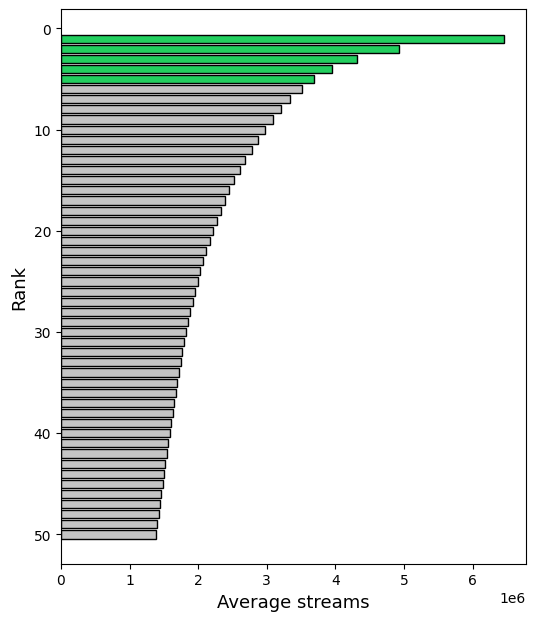

In [58]:
plt.figure(figsize=(6,7.2))
colors = ['#23CF5F' if i < 5 else '#C4C4C4' for i in range(len(stream_distribution_query['rank']))]
plt.barh(y=stream_distribution_query['rank'], width=stream_distribution_query['avg_streams'], edgecolor='black', color=colors)
plt.xlabel('Average streams', fontsize=13)
plt.ylabel('Rank', fontsize=13)
plt.gca().invert_yaxis()

In [1]:
# Percentage of streams in the top 5 positions (10th percentile) 

In [132]:
totstreams = pd.read_sql(f'''
SELECT SUM(avg_streams) as total_streams 
FROM(
{stream_distribution_querystr}
) as subquery 
''', spotify_conn)['total_streams']
print(totstreams)

0    1.160439e+08
Name: total_streams, dtype: float64


In [133]:
top10perc = pd.read_sql(f'''
SELECT SUM(avg_streams) as total_streams 
FROM(
{stream_distribution_querystr}
) as subquery 
WHERE rank<6
''', spotify_conn)['total_streams']

In [134]:
100*(top10perc/totstreams)

0    20.114081
Name: total_streams, dtype: float64

In [67]:
# 20 % of the streams in the top 50 Global songs are in the top 10% of rankings

In [68]:
# How many days will a song remain in the global Top 50?

In [50]:
days_global_top50_querystr = '''
SELECT 
title,
COUNT(title) as days_in_top50 
FROM spotify_charts 
WHERE chart='top200' and rank<51 and region='Global'
GROUP BY title
'''

In [51]:
days_global_top50_query = pd.read_sql(days_global_top50_querystr, spotify_conn)

In [35]:
days_global_top50_query

,days_in_top50
0,28
1,1
2,5
3,24
4,64
...,...
1962,213
1963,30
1964,154
1965,14


In [53]:
days_global_top50_query.to_sql('days_global_top50_query', spotify_conn, if_exists='replace', index=False)

1967

In [79]:
pd.read_sql("""
SELECT 
title,
days_in_top50
FROM days_global_top50_query
WHERE days_in_top50>700
""", spotify_conn)

,title,days_in_top50
0,Blinding Lights,749
1,Someone You Loved,744


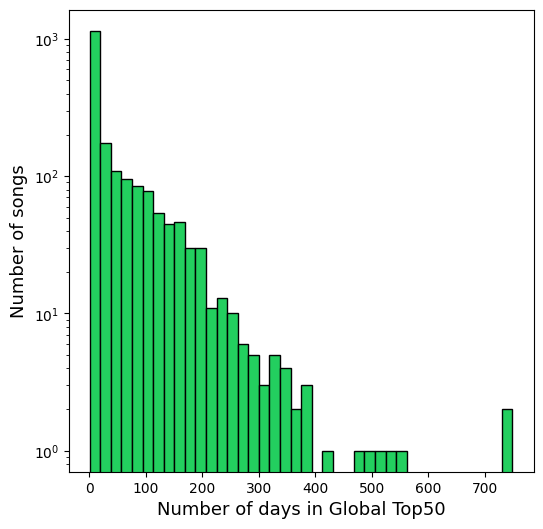

In [59]:
plt.figure(figsize=(6,6))
plt.hist(days_global_top50_query['days_in_top50'], bins=40, color ='#23CF5F', edgecolor='black', linewidth=1)
plt.yscale('log')
plt.xlabel('Number of days in Global Top50', fontsize=13)
plt.ylabel('Number of songs', fontsize=13)
plt.locator_params(axis='x', nbins=15)  # more ticks on x-axis
plt.show()

In [ ]:
# On average, how much does the probability of entering the Top 10 increase if the number of streams increases by 100,000?

In [25]:
rank_streams_top10 = pd.read_sql("""
SELECT 
(CASE WHEN rank<11 THEN 1 ELSE 0 END) as top10,
(streams/100000) as streams_hundred_thousand
FROM spotify_charts
WHERE rank<51 and chart='top200' and region='Global'
ORDER BY title
""", spotify_conn)
rank_streams_top10

,top10,streams_hundred_thousand
0,0,11.14690
1,1,24.08401
2,1,35.06717
3,1,35.81725
4,1,34.00510
...,...,...
90531,0,24.91909
90532,0,25.28626
90533,0,22.06870
90534,0,19.56489


(-0.1, 1.1)

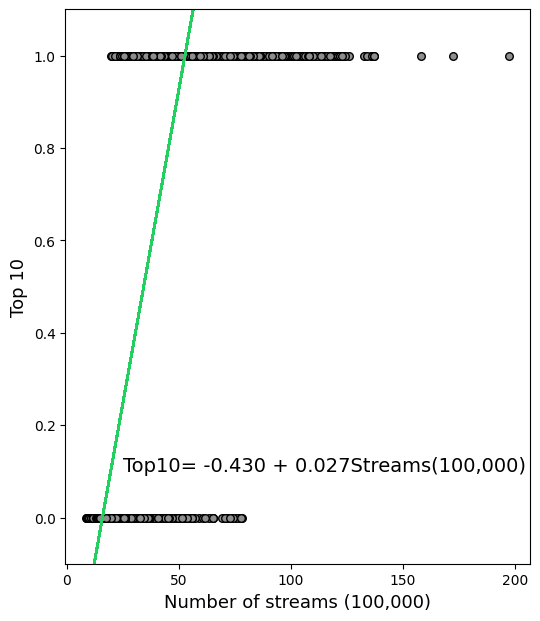

In [72]:
# Linear Probability Model OLS Regression
y = rank_streams_top10['top10']
X = rank_streams_top10['streams_hundred_thousand']

plt.figure(figsize=(6,7.2))
plt.xlabel('Number of streams (100,000)', fontsize=13)
plt.ylabel('Top 10', fontsize=13)

plt.scatter(x=X,y=y, linewidth=1, color='#8E8E8E', s=30, edgecolor='black')

# Line of best fit
plt.locator_params(axis='x', nbins=8) 
plt.locator_params(axis='y', nbins=8) 
a, b = np.polyfit(X,y, 1)
plt.plot(X, a*X+b, color='#23CF5F')

plt.text(25, 0.1, 'Top10= ' + '{:.3f}'.format(b) + ' + {:.3f}'.format(a) + 'Streams(100,000)', size=14)
plt.ylim([min(y) - 0.1, max(y) + 0.1])

In [31]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  top10   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                 1.112e+05
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:33:25   Log-Likelihood:                -9232.9
No. Observations:               90536   AIC:                         1.847e+04
Df Residuals:                   90534   BIC:                         1.849e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
# Google Trends data

In [2]:
google_trends = pd.read_csv("multiTimeline.csv")

In [3]:
google_trends.dtypes

date           object
spotify         int64
apple_music     int64
dtype: object

In [4]:
google_trends['date'] = pd.to_datetime(google_trends['date'], format="%d/%m/%Y")

In [5]:
Path('google_trends.db').touch()

In [6]:
trends_conn = sqlite3.connect('google_trends.db')
trends_cursor = trends_conn.cursor()

In [7]:
google_trends.to_sql('google_trends', trends_conn, if_exists='append', index=False)

51

In [14]:
trend_totals = pd.read_sql("""
SELECT
SUM(spotify) as total_spotify,
SUM(apple_music) as total_apple_music
FROM google_trends 
""", trends_conn)
search_ratio = trend_totals['total_spotify']/trend_totals['total_apple_music']

In [15]:
search_ratio

0    10.294931
dtype: float64

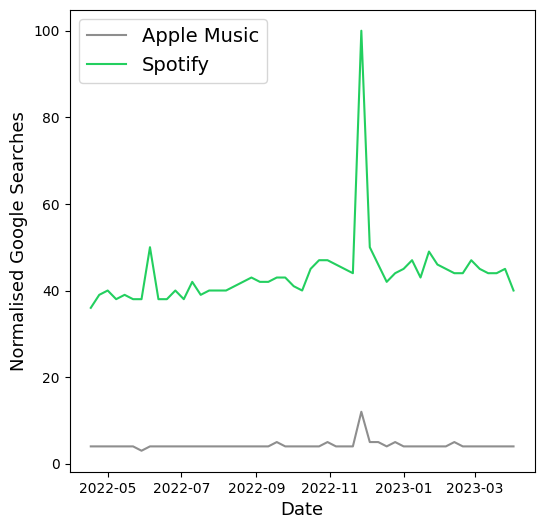

In [76]:
spotify_searches = google_trends['spotify']
apple_music_searches = google_trends['apple_music']
search_dates = google_trends['date']

plt.figure(figsize=(6,6))
plt.xlabel('Date', fontsize=13)
plt.ylabel('Normalised Google Searches', fontsize=13)
plt.plot(search_dates, apple_music_searches, color='#8E8E8E', label='Apple Music')
plt.plot(search_dates, spotify_searches, color='#23CF5F', label='Spotify')
plt.legend(prop={'size': 14}, loc='upper left')
plt.show()